Using Colab cache for faster access to the 'stanford-dogs-dataset' dataset.
Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Loading saved model...

--- PREDICTION RESULTS FOR: dog6.jpg ---
n02085620-Chihuahua       99.83%
n02107312-miniature_pinscher 0.09%
n02087046-toy_terrier     0.08%
n02094433-Yorkshire_terrier 0.00%
n02112706-Brabancon_griffon 0.00%
n02113978-Mexican_hairless 0.00%
n02105412-kelpie          0.00%
n02096585-Boston_bull     0.00%
n02104365-schipperke      0.00%
n02113186-Cardigan        0.00%
n02097047-miniature_schnauzer 0.00%
n02093754-Border_terrier  0.00%
n02108915-French_bulldog  0.00%
n02113624-toy_poodle      0.00%
n02107142-Doberman        0.00%
n02115913-dhole           0.00%
n02107908-Appenzeller     0.00%
n02109961-Eskimo_dog      0.00%
n02089078-black-and-tan_coonhound 0.00%
n02086910-papillon        0.00%
n02113023-Pembroke        0.00%
n02100583-viz

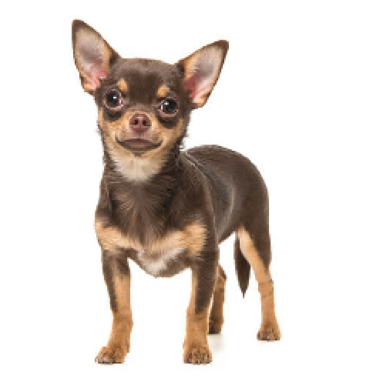

In [ ]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
import pathlib
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os
import matplotlib.pyplot as plt

mixed_precision.set_global_policy('mixed_float16')

path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
dataset_path = pathlib.Path(path) / "images" / "Images"

image_height = 240
image_width = 240
batch_size = 32


train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="training", seed=123,
    image_size=(image_height, image_width), batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path, validation_split=0.2, subset="validation", seed=123,
    image_size=(image_height, image_width), batch_size=batch_size
)

model_path = "dog_spotter_model.keras"

if os.path.exists(model_path):
    print("Loading saved model...")
    model = keras.models.load_model(model_path)
else:
    ## Train a new model
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.shuffle(200).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

    num_classes = 120

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(image_height, image_width, 3),
        include_top=False,
        weights='imagenet'
    )

    base_model.trainable = False

    model = keras.models.Sequential([
        keras.layers.Rescaling(1./127.5, offset=-1, input_shape=(image_height, image_width, 3)),

        base_model,

        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.2),

        keras.layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        jit_compile=True
    )

    model.summary()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50
    )

    model.save(model_path)
    print(f"Model saved to {model_path}")



def predict_dog_breed(image_path, model, class_names):
    if not os.path.exists(image_path):
        print(f"Error: Image {image_path} not found.")
        return

    img = load_img(image_path, target_size=(240, 240))
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_batch, verbose=0)

    n = 50
    top_n_indices = np.argsort(predictions[0])[::-1][:n]

    print(f"\n--- PREDICTION RESULTS FOR: {image_path} ---")

    for i in top_n_indices:
        breed = class_names[i]
        confidence = predictions[0][i] * 100
        print(f"{breed:<25} {confidence:.2f}%")

    print("---------------------------------------------")

    plt.imshow(img)
    plt.axis("off")
    plt.show()


class_names = train_ds.class_names

predict_dog_breed("content/dog6.jpg", model, class_names)